In [ ]:
# Install dependencies (uncomment if needed)
# !pip install -q opencv-python-headless matplotlib pillow numpy

In [3]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
def hsv_mask(img_bgr, lower=np.array([10, 100, 100]), upper=np.array([35, 255, 255])):
    """Return a binary mask from HSV thresholding.
    img_bgr: OpenCV BGR image
    lower/upper: HSV bounds (numpy arrays)
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    # Morphological cleaning
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    return mask

def apply_grabcut_from_mask(img_bgr, init_mask, iter_count=5):
    """Run GrabCut using the provided init_mask as probable foreground.
    init_mask: binary mask (255 foreground, 0 background)
    Returns final binary mask (0/255).
    """
    # Prepare mask for grabCut: 0=bg,1=fg,2=prob bg,3=prob fg
    gc_mask = np.full(init_mask.shape, cv2.GC_PR_BGD, dtype=np.uint8)
    gc_mask[init_mask == 0] = cv2.GC_BGD
    gc_mask[init_mask == 255] = cv2.GC_PR_FGD

    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    # run grabCut with mask initialization
    img_tmp = img_bgr.copy()
    cv2.grabCut(img_tmp, gc_mask, None, bgdModel, fgdModel, iter_count, cv2.GC_INIT_WITH_MASK)
    # final mask: pixels marked as FG or PR_FG become foreground
    mask_out = np.where((gc_mask == cv2.GC_FGD) | (gc_mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
    return mask_out

def postprocess_mask(mask, min_area=500):
    # close small holes and remove tiny components
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    # Remove small connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    out = np.zeros_like(mask)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            out[labels == i] = 255
    return out

def show_results(img_bgr, hsv_m, grab_m):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(1,3, figsize=(15,6))
    axs[0].imshow(img_rgb)
    axs[0].set_title('Original')
    axs[0].axis('off')
    axs[1].imshow(hsv_m, cmap='gray')
    axs[1].set_title('HSV mask (initial)')
    axs[1].axis('off')
    # overlay grabcut mask on image
    overlay = img_rgb.copy()
    alpha = 0.6
    overlay[grab_m==255] = (255*alpha + overlay[grab_m==255]*(1-alpha)).astype(np.uint8)
    axs[2].imshow(overlay)
    axs[2].set_title('GrabCut result (overlay)')
    axs[2].axis('off')
    plt.show()

In [5]:
# pick a sample image from dataset/ if available
root = Path('dataset')
img_path = None
if root.exists():
    for p in root.rglob('*.jpg'):
        img_path = p
        break

if img_path is None:
    print('No sample JPG found under dataset/. Please set `img_path` to an image file.')
else:
    print('Using', img_path)

Using dataset/H5/Vivo_26_H5f2_Kiri.jpg


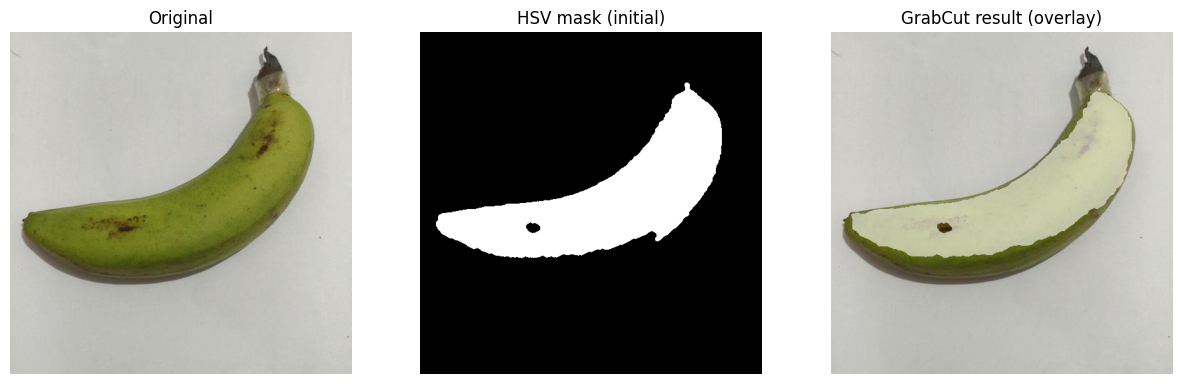

In [6]:
if img_path is not None:
    img = cv2.imread(str(img_path))
    # initial HSV mask (tweak ranges if needed)
    hsv_initial = hsv_mask(img, lower=np.array([10,100,100]), upper=np.array([35,255,255]))
    grab = apply_grabcut_from_mask(img, hsv_initial, iter_count=5)
    grab = postprocess_mask(grab, min_area=400)
    show_results(img, hsv_initial, grab)

### Batch processing
The next cell will run the pipeline over all images under `dataset/` and save binary masks to `segmented_masks/`. Masks are PNGs with 0/255 pixels.

In [ ]:
out_dir = Path('segmented_masks')
out_dir.mkdir(exist_ok=True)
if root.exists():
    for p in sorted(root.rglob('*.jpg')):
        img = cv2.imread(str(p))
        hsv_initial = hsv_mask(img)
        grab = apply_grabcut_from_mask(img, hsv_initial, iter_count=3)
        grab = postprocess_mask(grab, min_area=400)
        # save mask as PNG
        out_path = out_dir / (p.stem + '_mask.png')
        Image.fromarray(grab).save(out_path)
    print('Saved masks to', out_dir)
else:
    print('dataset/ not found; nothing to batch process.')